# FXa: evaluations using k conformations 30x4CV
## Data load and preprocessing

In [15]:
%run ./1_Helper_functions.ipynb

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [17]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.05


## Estimators
### ML Classifiers

In [18]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [19]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [20]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 10, 'learning_rate': 0.1, 
           'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0.5}
xgb = XGBClassifier(**hyparams)

In [21]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [22]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'GEO': get_geom_mean_score,
    'MIN': get_min_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [23]:
estimators = {**ml_classifiers, **cs_functions}

In [24]:
full_names = ['Log. Reg.', 
              'GBT', 
              'DummyClf', 
              'csAVG', 
              'csGEO',
              'csMIN'
             ]
new_names = dict(zip(estimators.keys(), full_names))

### Evaluation metrics 

In [25]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_12_Ra = {
                'metric_name': 'ef', 
                'fraction': R_a, 
                'method':'normalized'}
            )

# 10x4 CV with k conformations

## k-random conformations

In [26]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [27]:
main_dir = f'./cachedir/k_confs_30x4cv__GEOM/{protein_name}'
max_confs = X.shape[1]
k_values = [1, 2, 4, 8, 16, 32, 64, 128,  max_confs]

n_reps = 30
n_splits = 4
full_results = {}

## Random Selection

In [28]:
%%time

# ************
test_name = 'random'
full_results[test_name] = {}
# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    
    results = nk_rep_cross_validation_RANDOM_CONFS_SAVE(
                                filename=filename,
                                X=X, y=y, 
                                n_reps=n_reps, n_splits=n_splits,
                                k=k, max_confs=max_confs, 
                                metrics=metrics)
        
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = results


File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-random_30_rep

## REF preselected => XGB

In [29]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 
                         'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

In [30]:
%%time

# ************
test_name = 'RFExgb'
full_results[test_name] = {}
# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-RFExgb_30_rep

## Best conformations (single AUC-ROC score)

In [31]:
# Import the conformations features table
file=f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl'
with open(file, 'rb') as f:
    df_feat = pickle.load(f)

# Reset index to access each conformation per inx position
df_feat = df_feat.reset_index()

In [32]:
%%time

# ************
test_name = 'singConfAUC'
full_results[test_name] = {}

df_ranks = df_feat.sort_values('AUC-ROC', ascending=False)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_conf

## Worst conformations (single AUC-ROC score)

In [33]:
# Import the conformations features table
file=f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl'
with open(file, 'rb') as f:
    df_feat = pickle.load(f)

# Reset index to access each conformation per inx position
df_feat = df_feat.reset_index()

In [34]:
%%time

# ************
test_name = 'singConfAUC-Worst'
full_results[test_name] = {}

df_ranks = df_feat.sort_values('AUC-ROC', ascending=True)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-singConfAUC-Worst_30_reps_fxa_nConfs-128
Evaluation wit

## Conformations ranked by bigger inhibitors

In [35]:
%%time

# ************
test_name = 'bigLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=False)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigLigMW_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-con

## Conformations from smaller inhibitors

In [36]:
# %%time

# # ************
# test_name = 'smallLigMW'
# full_results[test_name] = {}
# df_ranks = df_feat.sort_values('Inhib. MW', ascending=True)

# # ************
# evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

# for k in k_values:
#     # Name the output file
#     filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
#     # Get the conformations using the selector
#     conformations = df_ranks.index[:k]
#     X_sub = X[:, conformations]
#     # Do the analysis
#     result = nk_rep_cross_validation_SAVE(
#                  filename=filename, 
#                  estimators=estimators, 
#                  X=X_sub, y=y, metrics=metrics, 
#                  n_repeats=n_reps,
#                  y_preds_return=False,
#                  random_state=42
#             )
#     print(f'Evaluation with k={k} finished.')
#     # *******************************
#     full_results[test_name][f'k_{k}'] = result


## Conformations with largest pocket volume

In [37]:
%%time

# ************
test_name = 'bigPkVolume'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Pk. Volume', ascending=False)

# ************
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'{main_dir}/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = nk_rep_cross_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_repeats=n_reps,
                 y_preds_return=False,
                 random_state=42
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs_30x4cv__GEOM/fxa/k-confs-bigPkVolume_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_conf

# Plot Results

In [38]:
full_results.keys()

dict_keys(['random', 'RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'bigPkVolume'])

In [39]:
full_names

['Log. Reg.', 'GBT', 'DummyClf', 'csAVG', 'csGEO', 'csMIN']

## AUC-ROC

In [66]:
# Faormat the results into a untidy dataframe
dict_df_results = {test_name: get_group_stats( df, 
                                   metric_name='roc_auc', 
                                   indexes_values=k_values).replace(new_names)
                   for test_name, df in full_results.items()}
df_roc = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())

In [67]:
metric_name='roc_auc'
single_mean_AUC, single_max_AUC = n_hold_out_single_performance(X, y, 
                metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

### Gradient Boosting

In [68]:
method='GBT'
metric='AUC-ROC'
df_ = df_roc.query(f'method == "{method}"')\
                        .reset_index().drop(['method', 'level_1'], 
                        axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



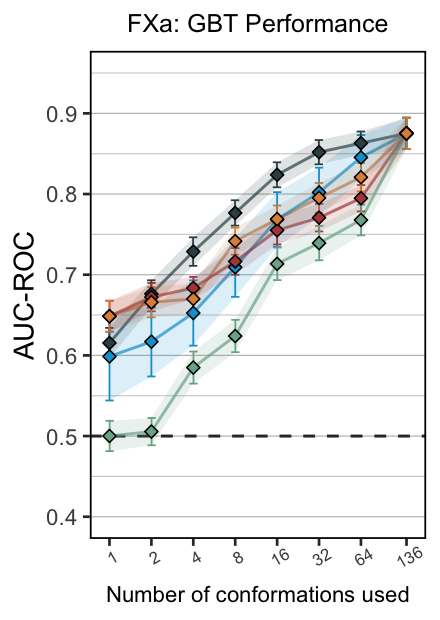

In [69]:
%%R -i full_names -i method -i metric  -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance')) 
# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

#### Para la Figura principal

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



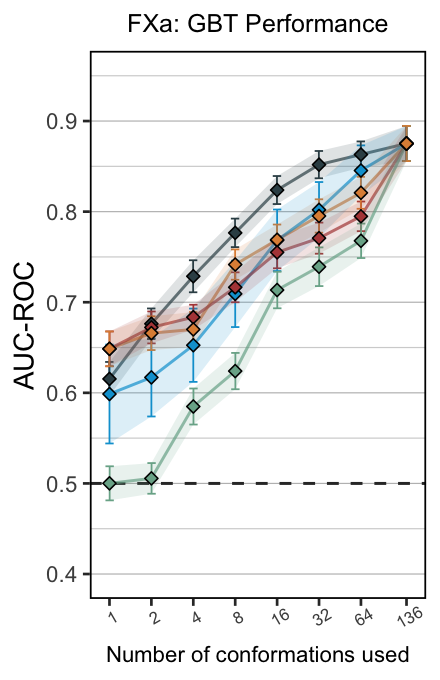

In [44]:
%%R -i full_names -i method -i metric -i single_max_AUC -i df_ -w 2.2 -h 3.4 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))


# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/MAIN_', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.4) 
p

### Logistic Regression 

In [45]:
method='Log. Reg.'
metric='AUC-ROC'
df_ = df_roc.query(f'method == "{method}"')\
                        .reset_index().drop(['method', 'level_1'], 
                        axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



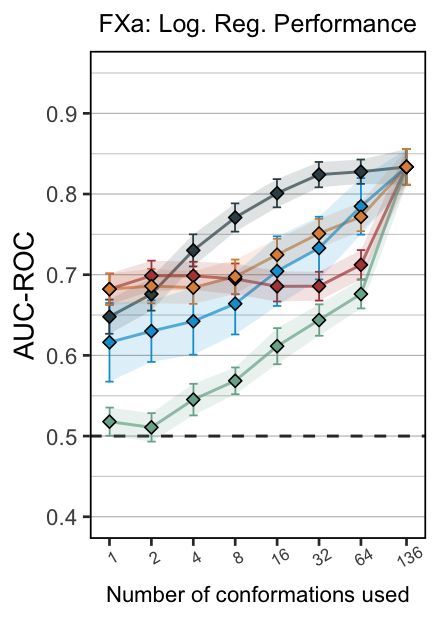

In [46]:
%%R -i full_names -i method -i metric -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMIN

In [47]:
method='csMIN'
metric='AUC-ROC'
df_ = df_roc.query(f'method == "{method}"')\
                        .reset_index().drop(['method', 'level_1'], 
                        axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



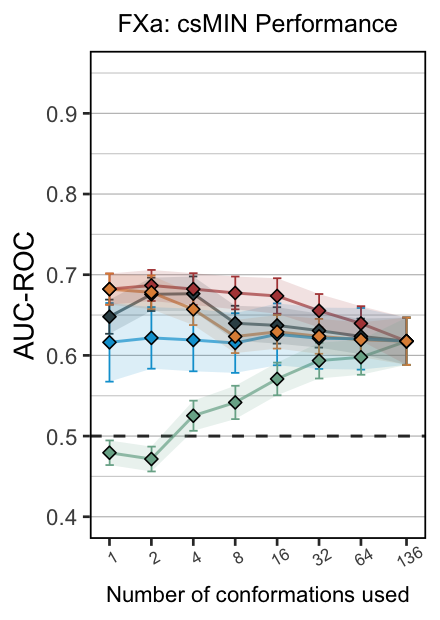

In [48]:
%%R -i full_names -i method -i metric  -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance')) 

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

#### Para la Figura Principal

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



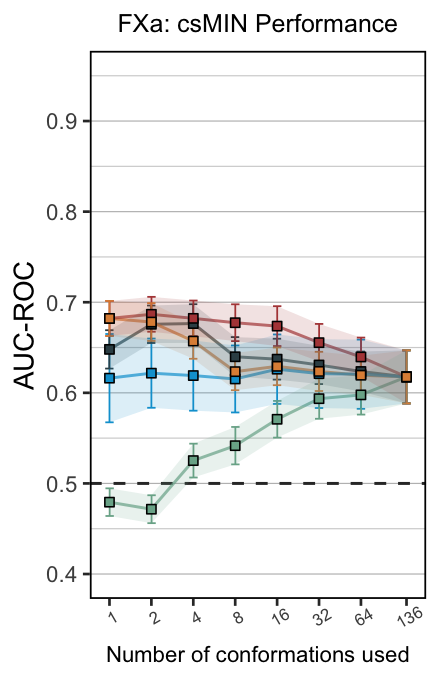

In [49]:
%%R -i full_names -i method -i metric -i single_max_AUC -i df_ -w 2.2 -h 3.4 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=22, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/MAIN_', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.4) 
p

### csAVG

In [50]:
method='csAVG'
metric='AUC-ROC'
df_ = df_roc.query(f'method == "{method}"')\
                        .reset_index().drop(['method', 'level_1'], 
                        axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



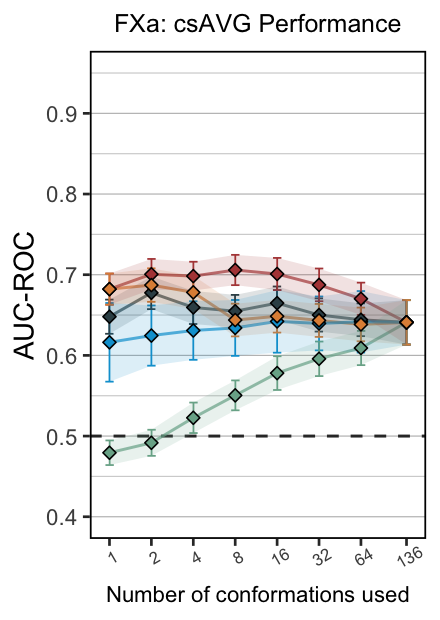

In [51]:
%%R -i full_names -i method -i metric -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csGEO

In [52]:
method='csGEO'
metric='AUC-ROC'
df_ = df_roc.query(f'method == "{method}"')\
                        .reset_index().drop(['method', 'level_1'], 
                        axis=1).rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



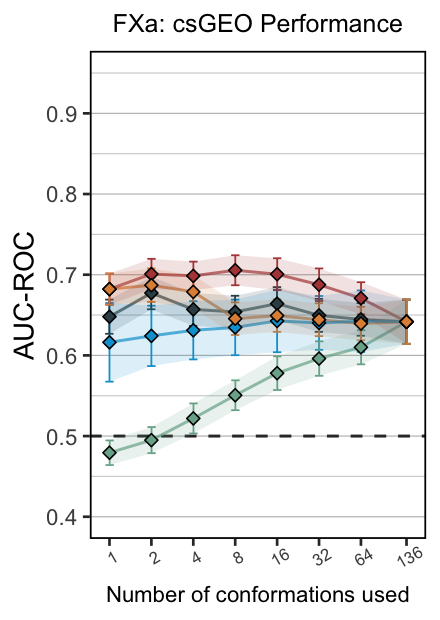

In [53]:
%%R -i full_names -i method -i metric -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst', 'bigLigMW', 'random'))
cbbPalette <- hue_pal()(10)

p = plot_lines(df, cbbPalette, y_min=0.4, y_max=0.95, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric, base_h_line=0.5, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

## NEF

In [54]:
# Format the results into a untidy dataframe
dict_df_results = {test_name: get_group_stats( df, 
                                   metric_name='nef_12_Ra', 
                                   indexes_values=k_values).replace(new_names)
                   for test_name, df in full_results.items()}

df_NEF = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())

In [55]:
single_mean_NEF, single_max_NEF = n_hold_out_single_performance(X, y, 
                metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

### XGB

In [56]:
method='GBT'
metric='NEF'
df_ = df_NEF.query(f'method == "{method}"')\
            .reset_index().drop(['method', 'level_1'], axis=1)\
            .rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



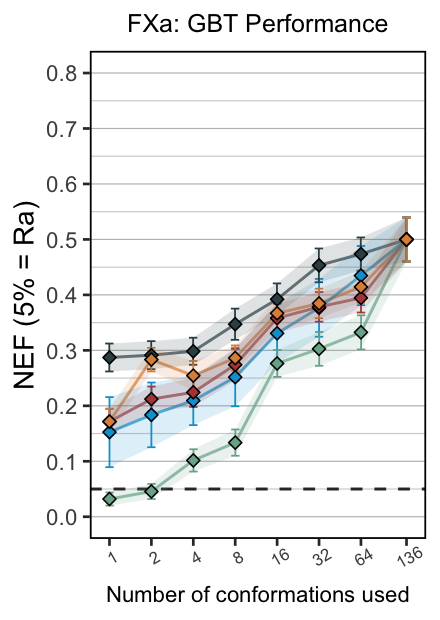

In [57]:
%%R -i full_names -i method -i metric -i R_a -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance')) 

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### Logistic Regression

In [58]:
method='Log. Reg.'
metric='NEF'
df_ = df_NEF.query(f'method == "{method}"')\
            .reset_index().drop(['method', 'level_1'], axis=1)\
            .rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



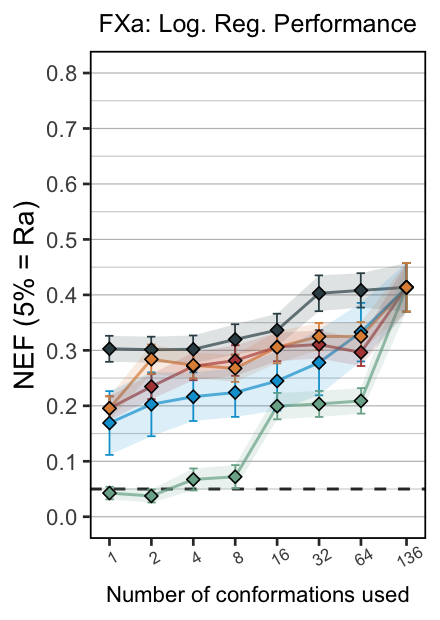

In [59]:
%%R -i full_names -i method -i metric -i R_a -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csMIN

In [60]:
method='csMIN'
metric='NEF'
df_ = df_NEF.query(f'method == "{method}"')\
            .reset_index().drop(['method', 'level_1'], axis=1)\
            .rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



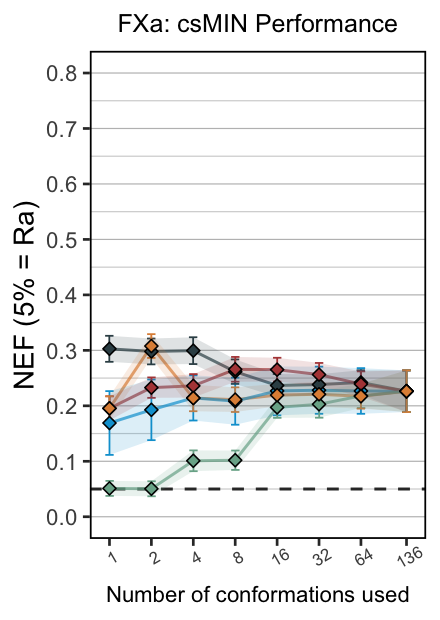

In [61]:
%%R -i full_names -i method -i R_a -i metric -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csAVG

In [62]:
method='csAVG'
metric='NEF'
df_ = df_NEF.query(f'method == "{method}"')\
            .reset_index().drop(['method', 'level_1'], axis=1)\
            .rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



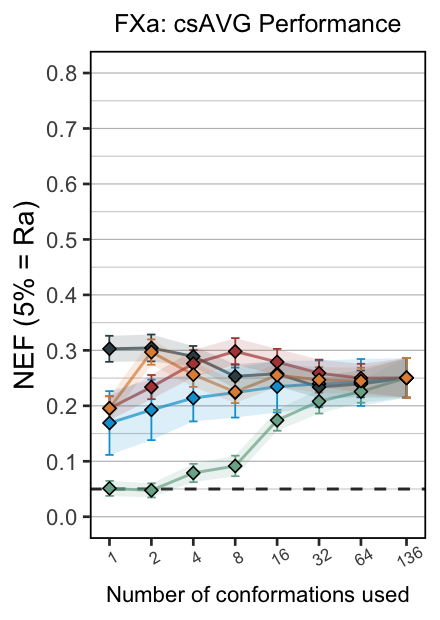

In [63]:
%%R -i full_names -i method -i R_a -i metric -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p

### csGEO

In [64]:
method='csGEO'
metric='NEF'
df_ = df_NEF.query(f'method == "{method}"')\
            .reset_index().drop(['method', 'level_1'], axis=1)\
            .rename(columns={'level_0': 'method'})

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



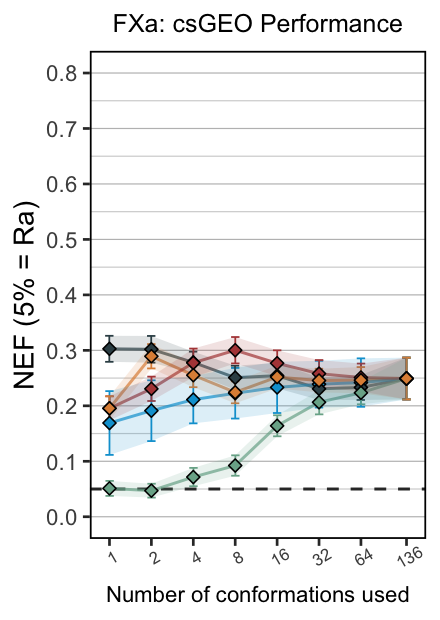

In [65]:
%%R -i full_names -i method -i R_a -i metric -i df_ -w 2.2 -h 3.1 --units in -r 200

library(ggsci)

source('./plotSwarmBox.R')
metric_name <- 'NEF (5% = Ra)'

x_ticks <- c(1,2,4,8,16,32, 64, 136)

df <- df_ %>%
    filter(index %in% x_ticks) %>%
    filter(method %in% c('RFExgb', 'singConfAUC', 'singConfAUC-Worst','bigLigMW', 'random'))

p <- plot_lines(df, cbbPalette, y_min=0.0, y_max=0.8, line_size=0.5, error_dodge=0.01, error_size=0.3,
               point_size=1.5, add_ribbon=T, ribbon_alpha=0.15,
               y_label=metric_name, base_h_line=R_a, switch_x=FALSE, error_width=1, 
               ticks.text.angle=30, ticks.text.size=6, shape=23, title.size=9,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks,  trans='log2') +
               scale_color_jama() + scale_fill_jama() +
               ggtitle(paste0('FXa: ', method, ' Performance'))

# Save the picture
protein_name <- 'fxa'
methodology <- paste0('conf-selection-', method)
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.1) 
p